# 打开股票量化的黑箱(自己动手实现一个‘印钞机’) 第四章

### 作者：阿布🐶

### 未经本人允许禁止转载

##  ‘非均衡胜负收益’带来的必然’非均衡胜负比例‘，目标由’因子‘的能力解决一部分，’模式识别‘提升关键的一部分

上一章使用机器学习的方法，想要提取特征，指导交易，提高胜率，但是发现，除了最后那种把交易结果分成100份的方式外，其它
机器学习方法基本都是瞎猜，是不是使用深度学习就能解决问题呢？

本章主要通过使用卷积神经网络模型alex_net,  与google_lenet对股票
进行模式识别

In [2]:
import ZEnv
import ZLog
import ZCommonUtil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100
%matplotlib inline

### 加载缓存交易数据

In [3]:
# 从之前跑的结果hdf5中加载缓存
from MlFiterDegPd import MlFiterDegPdClass
orders_pd_train_snap = ZCommonUtil.load_hdf5('orders_pd_train_snap', 'orders_pd_train_snap')
orders_pd_test_snap = ZCommonUtil.load_hdf5('orders_pd_test_snap', 'orders_pd_test_snap')
orders_pd_test_snap.shape
deg = MlFiterDegPdClass(orderPd=orders_pd_train_snap)
deg.x[:5], deg.y[:5]

(array([[  0.13997608,   0.07045403,   0.06829068],
        [ -0.40946745,  -0.38829941,   0.75027609],
        [ 11.84144398,  -0.84690618,   2.73882144],
        [-17.26610011,  -3.57896598,  -3.86127002],
        [ -9.14670563,   4.14514014,   2.85483688]]),
 array([ 0.,  0.,  0.,  0.,  1.]))

## 首先使用多层神经网络，明显也是不行

In [ ]:
from MlFiterTensorFlow import MnnTF
from sklearn.cross_validation import KFold

kf = KFold(len(deg.y), n_folds=10, shuffle=True)
for i, (train_index, test_index) in enumerate(kf):
    x_train, x_test = deg.x[train_index], deg.x[test_index]
    y_train, y_test = deg.y[train_index], deg.y[test_index]
    mnn = MnnTF(x_train, y_train, x_test, y_test, n_hidden_1=10, n_hidden_2=10, batch_size=len(deg.x)/2,
                 learning_rate=0.01, training_epochs=10000, display_step=1000)
    ac = mnn.fit()
    break # only once

Epoch: 0001 cost= 13.496154785


In [5]:
orders_pd_train_snap.ix[0].snap

'/Users/Bailey/Desktop/my_work/abu/data/save_png/2016-10-09/2016_10_09_12_06_59_042764_4241_lyQvysYoAwVoFylreOwxNXNXvvncdyyjDEjSORFMEUAfJBpLBHjXFbwQBUoZRtkO.png'

之前把所有交易前的snap都保留了(snap为交易前60日的k图)，这回不自己传入特征，直接使用卷积神经网络，自己学习特征
![img](./Snip20161014_5.png)

## 首先使用TensorFlow的高级api tflearn来实现alex_net的卷积神经网络

In [22]:
# 准备工作
import TrainValSplit
import os
import shutil

# 把结果cut 10份
def cut_order_profit_classes(orders_pd, test=False, n_classes=10):
    orders_pd.profit_cg.fillna(0, inplace=True)
    order_has_ret = orders_pd[(orders_pd.result <> 0)]
    order_has_ret['class'] = pd.qcut(order_has_ret.profit_cg, n_classes, labels=range(0, n_classes))
    order_has_ret['class'] = order_has_ret['class'].astype(int)
    snap_pd = order_has_ret.filter(['snap', 'class'])
    img_root_folder = os.path.dirname(snap_pd.ix[0].snap)
    img_root_folder = img_root_folder + '/'
    if test:
        img_root_folder += 'test/'  
    return snap_pd, img_root_folder

In [83]:
snap_pd, img_root_train_folder = cut_order_profit_classes(orders_pd_train_snap, test=False)
img_root_train_folder

'/Users/Bailey/Desktop/my_work/abu/data/save_png/2016-10-09/'

In [84]:
snap_pd_test, img_root_test_folder = cut_order_profit_classes(orders_pd_test_snap, test=True)
img_root_test_folder

'/Users/Bailey/Desktop/my_work/abu/data/save_png/2016-10-09/test/'

In [23]:
# 做子文件夹放分类图只是为了使用tflearn的build_image_dataset_from_dir方便
def make_sub_dir_mv(snap_pd, img_root_folder):
    target_dir = img_root_folder 
    map(lambda cls: os.makedirs(target_dir + str(cls) + '/') 
        if not os.path.exists(target_dir + str(cls) + '/') else 1, np.arange(0, 10))
    
    for ind in np.arange(0, len(snap_pd)):
        path = snap_pd.ix[ind]['snap']
        cls  = snap_pd.ix[ind]['class']
        
        target_path = target_dir + str(cls) + '/' + os.path.basename(path)
        if os.path.exists(target_path):
            continue
        
        shutil.move(path, target_path)
    snap_pd['snap'] = snap_pd.apply(lambda snap: str(snap['class']) + '/' + os.path.basename(snap.snap), axis=1)

In [65]:
# 移动训练集snap
make_sub_dir_mv(snap_pd, img_root_train_folder)
# 移动测试集snap
make_sub_dir_mv(snap_pd_test, img_root_test_folder)
snap_pd.head()

,snap,class
2015-09-11,1/2016_10_09_18_15_39_583096_6110_JSNTMWgcqKcT...,1
2015-09-11,5/2016_10_09_18_06_02_707471_6110_oBSQVzUkhtPd...,5
2015-09-11,5/2016_10_09_18_12_20_586317_6110_JLshhttghRuO...,5
2015-09-11,0/2016_10_09_17_59_44_188534_6110_IcMNqzQqybsW...,0
2015-09-11,0/2016_10_09_18_18_28_393821_6110_wqmNPNBFlTmU...,0


In [44]:
# 将训练集和测试集的png都转换为rgb的jpeg
import ImgStdHelper
to = img_root_train_folder
for ind in np.arange(0, 10):
    std_dir = to + str(ind) + "/"
    ImgStdHelper.std_img_from_root_dir(std_dir, 'png')
to = img_root_test_folder
for ind in np.arange(0, 10):
    std_dir = to + str(ind) + "/"
    ImgStdHelper.std_img_from_root_dir(std_dir, 'png')

In [85]:
snap_pd.snap = snap_pd.snap.apply(lambda snap: snap[:-4] + '.jpeg')
snap_pd_test.snap = snap_pd_test.snap.apply(lambda snap: snap[:-4] + '.jpeg')

### 获取训练数据

In [ ]:
from tflearn.data_utils import build_image_dataset_from_dir

dataset_file = ZEnv.g_project_root + '/Caffe/gen/stock_tensor.pkl'
one_hot=True, 
resize_pics=(227, 227)
x, y = build_image_dataset_from_dir(img_root_train_folder,
                             dataset_file=dataset_file,
                             resize=resize_pics,
                             filetypes=['.jpg', '.jpeg'],
                             convert_gray=False,
                             shuffle_data=True,
                             categorical_Y=one_hot)

### 使用tflear开始训练

In [35]:
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
network = input_data(shape=[None, 227, 227, 3])
network = conv_2d(network, 96, 11, strides=4, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = conv_2d(network, 256, 5, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = conv_2d(network, 384, 3, activation='relu')
network = conv_2d(network, 384, 3, activation='relu')
network = conv_2d(network, 256, 3, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = fully_connected(network, 4096, activation='tanh')
network = dropout(network, 0.5)
network = fully_connected(network, 4096, activation='tanh')
network = dropout(network, 0.5)
network = fully_connected(network, 10, activation='softmax')
network = regression(network, optimizer='momentum',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)
model = tflearn.DNN(network, checkpoint_path='model_alexnet',
                    max_checkpoints=1, tensorboard_verbose=2)
model.fit(x, y, n_epoch=1000, validation_set=0.1, shuffle=True,
          show_metric=True, batch_size=64, snapshot_step=200,
          snapshot_epoch=False, run_id='alexnet_stock')

In [29]:
# 抽取100张作为测试，每个class抽取10张
fr = img_root_test_folder
to = img_root_test_folder + 'choice_test/'

for ind in np.arange(0, 10):
    ff = fr + str(ind) + "/*.jpeg"
    imglist = glob.glob(ff) 
    imglist = np.random.choice(imglist, 10, replace=False)
    for img in imglist:
        img_to = to + str(ind) + "/" + os.path.basename(img)
        ZCommonUtil.ensure_dir(img_to)
        shutil.copy(img, img_to)
        
# 加载测试数据        
dataset_file_test = ZEnv.g_project_root + '/Caffe/gen/stock_tensor_test.pkl'
print(dataset_file_test)
one_hot=True, 
resize_pics=(227, 227)
test_folder = to
x_test, y_test = build_image_dataset_from_dir(test_folder,
                             dataset_file=dataset_file_test,
                             resize=resize_pics,
                             filetypes=['.jpg', '.jpeg', '.png'],
                             convert_gray=False,
                             shuffle_data=True,
                             categorical_Y=one_hot)

/Users/Bailey/Desktop/my_work/abu/Caffe/gen/stock_tensor_test.pkl


In [33]:
x_test.shape, y_test.shape

((100, 227, 227, 3), (100, 10))

In [41]:
test_ret = model.predict(x_test)
test_cnt = len(test_ret)
rt_cnt = 0
for pred_y, real_y in zip(test_ret, y_test):
    real_y = np.argmax(real_y)
    f = np.argmax(pred_y)
    if f == real_y:
        rt_cnt += 1
        continue
        
    pred_y[f] = 0
    t = np.argmax(pred_y)
    if t == real_y:
        rt_cnt += 1
        continue
        
    pred_y[t] = 0
    ttt = np.argmax(pred_y)
    if ttt == real_y:
        rt_cnt += 1
        continue
rt_cnt, test_cnt

(58, 100)

## top3的准确率达到 58%，稍为加工一下就可以放到程序里作为优化器了，使用方式类似:单子买入之前对below 3和top3进行判断，如果在below3中且不top3在中进行拦截，当然也可以有更多变种，关于这方面的实例将会在后续章节hmm-gmm中演示，更会延伸到裁判机制

______

## 接下来使用caffe进行训练，优化
## 使用google_lenet看看能不能有再次提升

In [75]:
snap_pd.shape

(4612, 2)

In [95]:
def caffe_train_sh(snap_pd, img_root_folder):
    train_path = ZEnv.g_project_root + '/caffe/gen/train.txt'
    ZCommonUtil.ensure_dir(train_path)
    snap_pd.to_csv(train_path, sep=' ', header=None, index=False)
    TrainValSplit.train_val_split(train_path, n_folds=10)
    lmdb = ZEnv.g_project_root + '/Caffe/sh/Lmdb.sh'
    out_put_dir = ZEnv.g_project_root + '/Caffe/gen'
    sh_cmd = '{} ${} ${}'.format(lmdb, img_root_folder, out_put_dir) 
    print(sh_cmd)
    os.system(sh_cmd)
    return sh_cmd

### 生成训练测试集，之后生成lmdb 及 mean pb

In [96]:
sh_cmd = caffe_train_sh(snap_pd, img_root_train_folder)

/Users/Bailey/Desktop/my_work/abu/Caffe/sh/Lmdb.sh $/Users/Bailey/Desktop/my_work/abu/data/save_png/2016-10-09/ $/Users/Bailey/Desktop/my_work/abu/Caffe/gen


### 关于其它配置，请自己查看代码pb文件，训练完模型之后先拿一个测试看看效果

In [152]:
path = img_root_test_folder + snap_pd_test.ix[0].snap
classes = snap_pd_test.ix[0]['class']
path, classes

('/Users/Bailey/Desktop/my_work/abu/data/save_png/2016-10-09/test/1/2016_10_09_18_15_39_583096_6110_JSNTMWgcqKcTwDJeRrHlYvCsqSlRjeLwZdJpJvVzsATDYMLKkUFOhqraqoZGHqkm.jpeg',
 1)

### 加载训练好了的模型

In [153]:
import caffe
caffe.set_mode_cpu()

image = caffe.io.load_image(path)
model_def = ZEnv.g_project_root + '/Caffe/pb/deploy.prototxt' 
model_weights = ZEnv.g_project_root + '/Caffe/gen/stock_judge_train_iter_6000.caffemodel'
model_mean_file = ZEnv.g_project_root + '/Caffe/gen/mean.binaryproto'

net = caffe.Net(model_def, model_weights, caffe.TEST)  

mean_blob = caffe.proto.caffe_pb2.BlobProto()
mean_blob.ParseFromString(open(model_mean_file, 'rb').read())
mean_npy = caffe.io.blobproto_to_array(mean_blob)
mu = mean_npy.mean(2).mean(2)[0]
print('mu = {}'.format(mu))
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  
transformer.set_mean('data', mu)           
transformer.set_raw_scale('data', 255)     
transformer.set_channel_swap('data', (2,1,0))  

mu = [ 243.24985442  238.91917917  239.75766282]


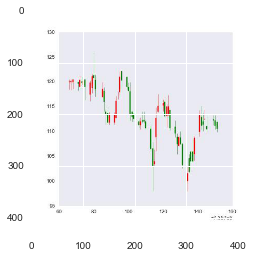

In [154]:
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)
plt.show()

In [155]:
net.blobs['data'].data[...] = transformed_image
output = net.forward()
output_prob = output['prob'][0]
print('demo classes is {}'.format(classes))
print('predicted class is:', output_prob.argmax())
print('Top3 is:', output_prob.argsort()[::-1][:3])

demo classes is 1
('predicted class is:', 7)
('Top3 is:', array([7, 3, 1]))


如下， 测试数据集的头100个作为测试
计算top3与top5的准确率
top3: 54%
top5: 63%

In [157]:
top3 = 0
top5 = 0
for ind in np.arange(0, 100):
    path = img_root_test_folder + snap_pd_test.ix[ind].snap
    classes = snap_pd_test.ix[ind]['class']
    
    image = caffe.io.load_image(path)
    net.blobs['data'].data[...] = transformed_image
    output = net.forward()
    output_prob = output['prob'][0]
    if classes in output_prob.argsort()[::-1][:3]:
        top3 += 1
        top5 += 1
    elif classes in output_prob.argsort()[::-1][:5]:
        top5 += 1
top3, top5

(54, 63)



### 使用深度学习确实对整个模式识别相比其它机器学习方法有了很大的飞跃，有了这个特征识别能力，就可以总结出新的交易拦截能力，进一步提升胜率，假想一下你的整个模型能力能有60的胜率而且每次赢的还比输的多，那它是不是就可以称为印钞机呢，当然了还有很多其它因素影响了印钞机的具体工作，这里无法一一阐述，有兴趣的可以加我的微信一起讨论！

## 感谢🙏您能有耐心看到这里
## 如果有什么问题可以加阿布的微信 
## 微信号：aaaabbbuu

![image](./mmexport1475383814280.jpg)